In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re, nltk, spacy, string
from collections import defaultdict

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

import plotly.express as px
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)
from IPython.display import Image
#nltk.download('wordnet') # must do first time if you do not already have this

import warnings 
warnings.filterwarnings('ignore')

# What is, our Case Studies Final? 
#### Veeral, Catie, and Dash

## Question 1

Welcome to "Jeopardy!" with your hosts Catie, Dash and Veeral! We look forward to taking you though an in-depth analysis of the topics in Jeopardy! We begin our journey with how we chose our k topics for our analysis. We originally choose our number of topics based on a priori information on the most popular topics in Jeopardy! (https://www.cinemablend.com/television/10-Most-Common-Jeopardy-Categories-70856.html). Our analysis began with 11 topics and through some EDA, and general analysis, we eventually brought that number down to 8 topics. Fun fact, one of the original topics was picking up on the word “new” so it was just a bunch of places like New York, New Jersey, etc… In order to further explore this dataset, we decided to take a (seemingly) different approach than the rest of our classmates. In this project we run NMF on the entire dataset to get topics 8 topics of Jeopardy! and we then see how the "distribution" of these topics change over time.

In [2]:
jeop = pd.read_csv('JEOPARDY_CSV.csv', parse_dates=[' Air Date'])
jeop['Year'] = jeop[' Air Date'].dt.year

In [3]:
sw = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
def clean(doc):
    normalized = " ".join(lemma.lemmatize(word.lower()) for word in doc.split())    
    return normalized

In [4]:
for word in ['type','new','called','wa','ha','like',"also",'name','one','may','might']:
    sw.add(word)

In [5]:
vect = TfidfVectorizer(max_df=.5, min_df=5 ,stop_words=sw)
X = vect.fit_transform(jeop[' Question'].apply(clean))
model = NMF(n_components=8, random_state=0, solver='mu')
model.fit(X)
nmf_features = model.transform(X)
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())

In [6]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 0 the words with the highest value are:
com        2.258643
www        2.256616
archive    2.256470
http       2.255958
href       2.255611
media      2.255436
_blank     2.057304
target     2.056505
jpg        2.053038
seen       0.752227
Name: 0, dtype: float64


For topic 1 the words with the highest value are:
first        5.073930
became       1.048531
year         0.490135
woman        0.472206
president    0.471669
american     0.431893
lady         0.362209
time         0.318087
published    0.222094
win          0.219987
Name: 1, dtype: float64


For topic 2 the words with the highest value are:
city       4.490351
capital    1.594156
largest    0.780226
river      0.423078
world      0.370755
york       0.357068
home       0.352016
founded    0.245764
island     0.228055
named      0.210177
Name: 2, dtype: float64


For topic 3 the words with the highest value are:
word       3.236352
letter     1.231169
come       0.984739
mean       0.963332
term       0.872664
me

In [10]:
jeop['target'] = pd.Series(np.argmax(nmf_features,axis=1))
topics = ['Image & Video', 'Firsts', 'Cities & Capitals', 'Words', 'States', 'World', 'Culture', 'History']
target2topic = dict(zip(range(8),topics))
jeop['topic'] = jeop['target'].map(target2topic)

groupdf = jeop.groupby(['Year','topic'])[' Question'].count().reset_index()
groupdf2 = groupdf.set_index('Year').merge(groupdf.groupby('Year')[' Question'].sum().reset_index(),on='Year')
groupdf2['Question_pct'] = groupdf2[' Question_x']*100 / groupdf2[' Question_y'] 

In [11]:
topic = 'World'
jeop[jeop['topic']==topic].groupby([' Category','topic'])[' Question'].count().sort_values(ascending=False).iloc[:15]

 Category               topic
ISLANDS                 World    212
WORLD GEOGRAPHY         World    206
BODIES OF WATER         World    164
WORLD HISTORY           World    148
GEOGRAPHY               World    132
LANGUAGES               World    128
COUNTRIES OF THE WORLD  World    113
HISTORY                 World    110
AROUND THE WORLD        World     95
MOUNTAINS               World     91
U.S. GEOGRAPHY          World     69
EUROPEAN HISTORY        World     63
LAKES & RIVERS          World     54
AMERICAN HISTORY        World     52
ANIMALS                 World     49
Name:  Question, dtype: int64

We concluded that these topics seem to make sense and the words are meaningful! Go team! From here we decided to manually give each of these topics a label so that our analysis was more user friendly. We were pleased to see that our manually added labels match the  categories of the questions. Once we had our eight, labeled topics, we analyzed the prevalence of these topics over time.

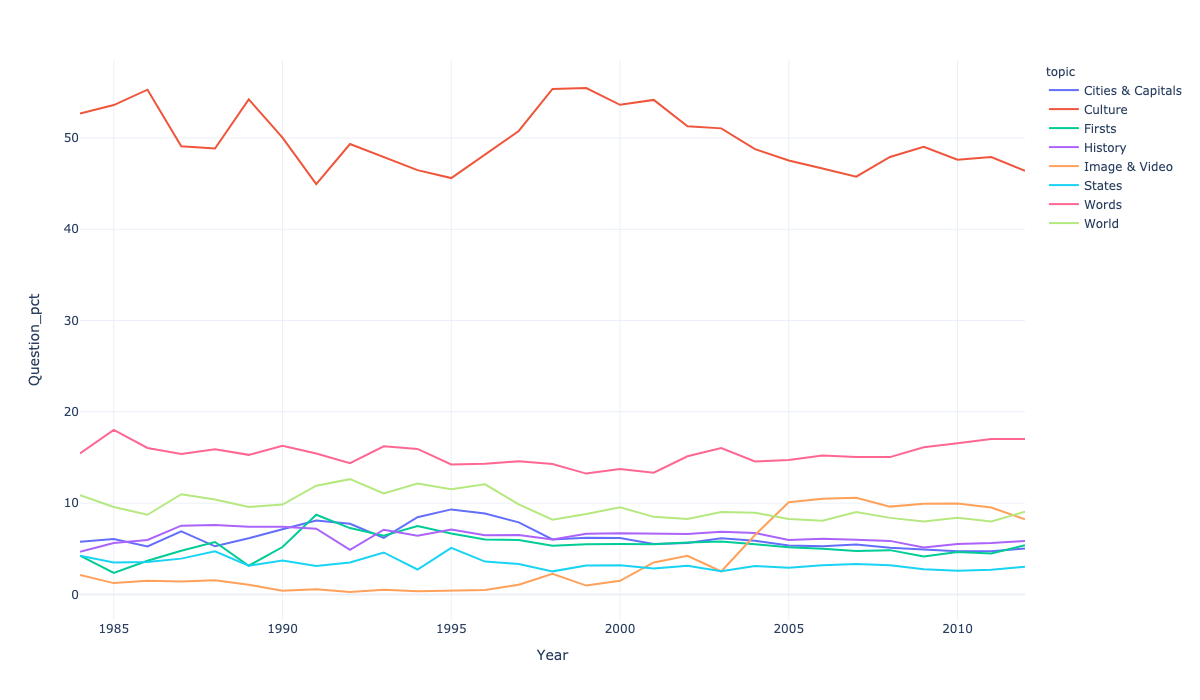

In [12]:
fig = px.line(groupdf2, x='Year',y='Question_pct', color='topic',template='plotly_white')
image_bytes = fig.to_image(format='png', width=1200, height=700, scale=1) 
Image(image_bytes)


## How have the thematic topics of the game’s questions have changed over the past 35 years?

While there does seem to be overall stability, there are also obvious dynamic changes in the makeup of the questions asked on the show. For example, there is an almost 10% increase in culture-based questions on the show between 1995 and 1997. 

Additionally, Culture has always been around 50% of the questions asked in Jeopardy! For any given year. This makes sense as the culture topic covers a wide variety of categories such as movies, books, songs, etc... While some years have more "culture" than others, we see that it consistently outweighs the other seven topics. This also made sense to us since these culture based questions tend to be more "traditional" trivia style questions. 

When looking at the mid 2000s, we noticed a sharp increase in the percentage of Image and Video based questions. The technological advances of the early 2000s allowed for the producers to more seamlessly integrate multimedia questions. 

Another discovery of note is that “word”  or word play based questions have always been popular. These “word” questions such as the category “Dynamic Duo” is a "fan favorite" and has lasted the test of time (well 35 years to be exact). 


In [13]:
jeopordy = jeop[jeop[' Round']=='Jeopardy!']
doub_jeopordy = jeop[jeop[' Round']=='Double Jeopardy!']
final_jeopordy = jeop[jeop[' Round']=='Final Jeopardy!']
groupdf = jeopordy.groupby(['Year','topic'])[' Question'].count().reset_index()
groupdf1 = groupdf.set_index('Year').merge(groupdf.groupby('Year')[' Question'].sum().reset_index(),on='Year')
groupdf1['Question_pct'] = groupdf1[' Question_x']*100 / groupdf1[' Question_y'] 
groupdf = doub_jeopordy.groupby(['Year','topic'])[' Question'].count().reset_index()
groupdf2 = groupdf.set_index('Year').merge(groupdf.groupby('Year')[' Question'].sum().reset_index(),on='Year')
groupdf2['Question_pct'] = groupdf2[' Question_x']*100 / groupdf2[' Question_y']
groupdf = final_jeopordy.groupby(['Year','topic'])[' Question'].count().reset_index()
groupdf3 = groupdf.set_index('Year').merge(groupdf.groupby('Year')[' Question'].sum().reset_index(),on='Year')
groupdf3['Question_pct'] = groupdf3[' Question_x']*100 / groupdf3[' Question_y']

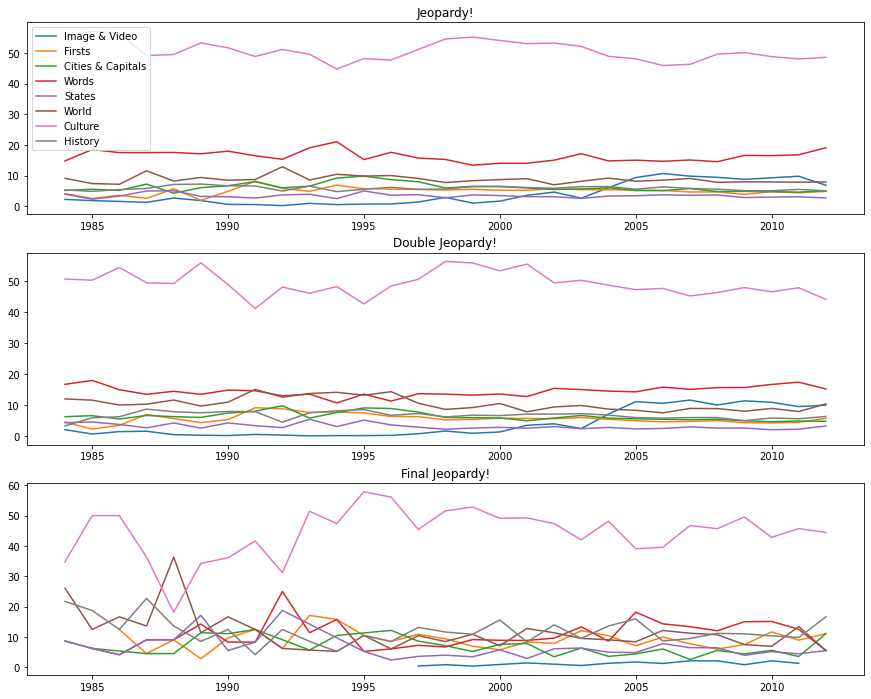

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,12))
topics = ['Image & Video', 'Firsts', 'Cities & Capitals', 'Words', 'States', 'World', 'Culture', 'History']
for topic in topics:
    data = groupdf1[groupdf1.topic==topic]
    ax1.plot(data.Year, data.Question_pct, label = topic)
for topic in topics:
    data = groupdf2[groupdf2.topic==topic]
    ax2.plot(data.Year, data.Question_pct, label = topic)
for topic in topics:
    data = groupdf3[groupdf3.topic==topic]
    ax3.plot(data.Year, data.Question_pct, label = topic)

ax1.title.set_text('Jeopardy!')
ax2.title.set_text('Double Jeopardy!')
ax3.title.set_text('Final Jeopardy!')
    
ax1.legend(loc='upper left')
plt.show()



Finally, we were interested to see how the percentage of these topics change in each round over time. We see the largest change in topics in the final jeopardy round. Not only are there large shifts in the percentage of culture questions, but we also see that image and video based questions are not introduced in final jeopardy until about 10 years after they were used in the jeopardy and double jeopardy rounds. Additionally, the variance in final jeopardy seems to be high year to year compared to jeopardy and double jeopardy! Otherwise, it seems that the topics follow the same trends as seen when we did not separate by round.



## Question 2

#### What happens if we look at these topics and their value in the game? 

In this question we are interested in exploring the connection between the topics we discovered and the value of those topics (which in Jeopardy! we can treat as the difficulty of the question). 


In [15]:
jeop['Value'] = jeop[' Value'].str.replace('[$,]','',regex=True)
jeop = jeop[jeop['Value']!='None']
jeop['Value'] = jeop['Value'].astype(int)

vals = jeop.groupby('topic').mean()['Value']

vals

topic
Cities & Capitals    730.695418
Culture              725.455800
Firsts               737.149144
History              785.374216
Image & Video        956.046613
States               699.342003
Words                769.503913
World                762.121517
Name: Value, dtype: float64

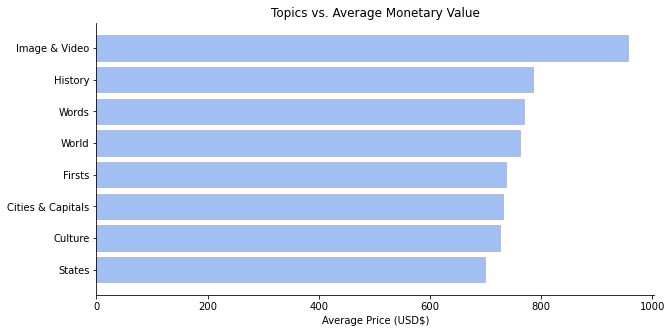

In [16]:
vals = vals.sort_values(ascending=False)

fp = dict(vals)

k = [f'{i}' for i in fp.keys()]

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(k, list(fp.values()), alpha =.6,  color='cornflowerblue')
ax.set_title('Topics vs. Average Monetary Value')
ax.set_xlabel('Average Price (USD$)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(range(8))
for patch in ax.patches:
    patch.set_edgecolor('darkgrey')
ax.invert_yaxis()
plt.show()


Here we see that the average price of the "Image and Video" questions is the highest! We realized that the daily double questions are often image or video based questions so it would make sense for these questions to have a higher average value. Conversely, since the culture topic tends to be the majority of the questions in a given year, it makes sense that it may have a slightly lower average value as it has more observations to pull the average down. The rest of main topics we found, have similar average values which leads us to believe the writers try to distribute these topics evenly. However, we do note that states seem to have a lower average score compared to the other topics. 


In [17]:
val2 = jeop.groupby('topic').median()['Value']

val2

topic
Cities & Capitals    600
Culture              600
Firsts               600
History              600
Image & Video        800
States               500
Words                600
World                600
Name: Value, dtype: int64

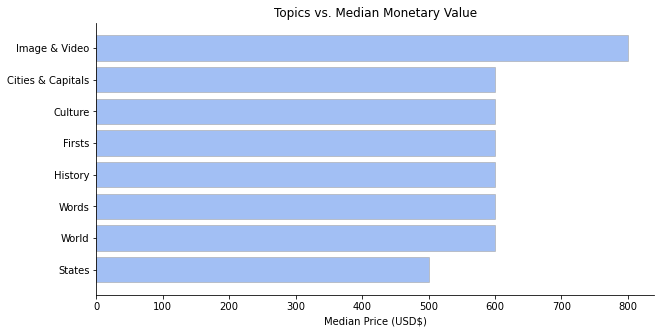

In [18]:
val2 = val2.sort_values(ascending=False)

fp2 = dict(val2)

k2 = [f'{i}' for i in fp2.keys()]

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(k2, list(fp2.values()), alpha =.6,  color='cornflowerblue')
ax.set_title('Topics vs. Median Monetary Value')
ax.set_xlabel('Median Price (USD$)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(range(8))
for patch in ax.patches:
    patch.set_edgecolor('darkgrey')
ax.invert_yaxis()
plt.show()



Since there are different numbers of documents in each topic, we also wanted to explore the median value so that outliers in some categories are not affecting our analysis. It was again interesting to see Image and Video have the highest value as we can now say their average higher value, as reported above, is not being strongly influenced by a couple of outliers. Similarly, we see that the majority of the topics actually have the same median price, which is supported by the visualizations below which show the distribution of question value in each topic. Finally, we really found it interesting that state based questions were worth less on average. So, if you ever make it onto Jeopardy! and you get a state question, rejoice! 


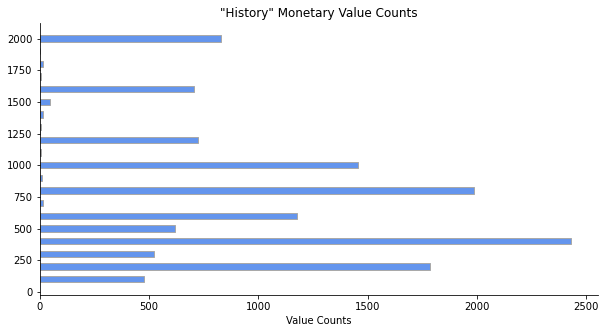

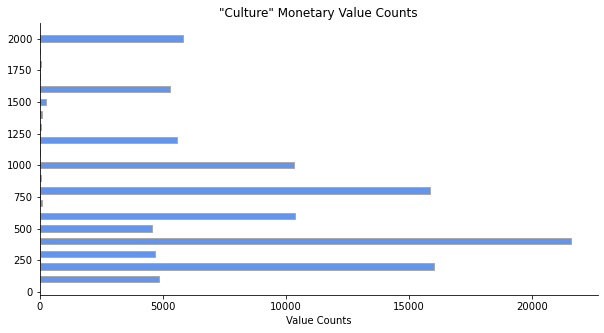

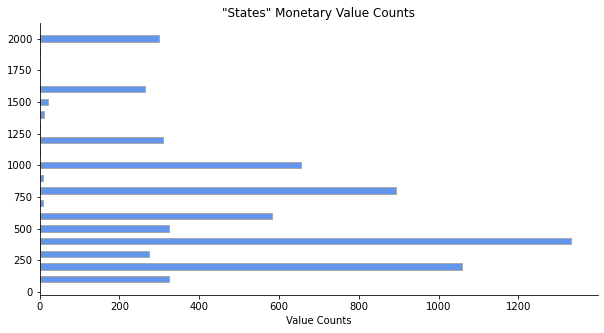

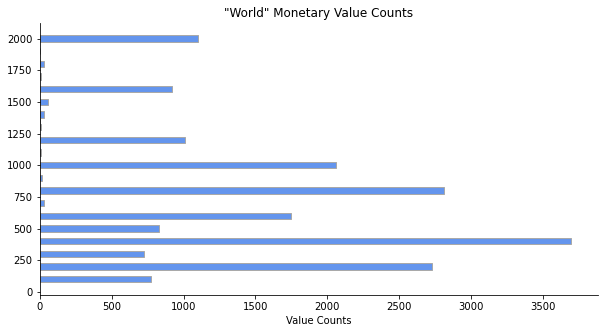

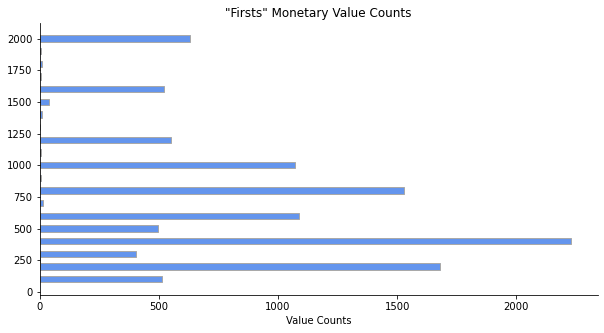

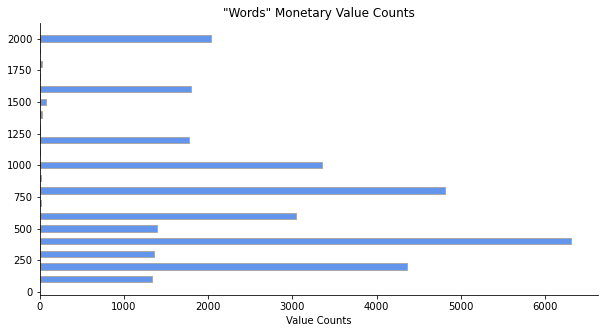

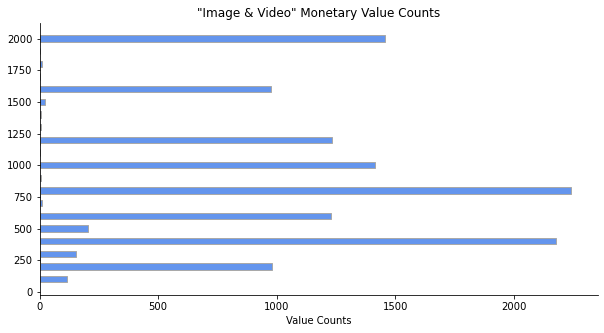

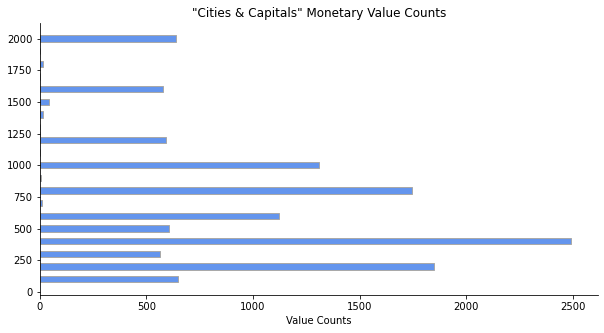

In [19]:
d = dict(jeop.groupby(['topic','Value']).count()['Year'])

fp2 = {}
for val in d:
    targ = val[0]
    value = val[1]
    count = d[val]
    if value>2000 or value<100:
        continue
    if targ in fp2.keys():
        fp2[targ][value] = count
    else:
        fp2[targ] = dict()
        fp2[targ][value] = count
    

for i in jeop['topic'].unique():
    new = fp2[i]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.barh(list(new.keys()), list(new.values()), height=50,  color='cornflowerblue')
    ax.set_title(f'\"{i}\" Monetary Value Counts')
    ax.set_xlabel('Value Counts')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for patch in ax.patches:
        patch.set_edgecolor('darkgray')
    plt.show()



## What happens if we look at how these values change over the years? 

We now are interested in seeing any patterns in topic value from year to year. Are some topics more difficult for a few years and then they get easier or do we see consistent difficulty across topics? We first concentrated on questions that have the round value “Jeopardy!” and plotted the topics average dollar value across each year. We did the same for “Double Jeopardy”. If we look to the visualizations below, we can see that most topics follow a similar pattern across all years except for the topic Image & Video. Before the early 2000s, questions from topic Image & Video seemed to be thought of as being the hardest of all possible Jeopardy questions. This dynamic is easy to understand as it would be difficult to add a video with the technology available back then, so they wanted to make it worth it. While it seems that the masterminds of Jeopardy still thought the topic Image & Video was difficult in the late 2000s and beyond, its relative magnitude in difficulty to the other topic questions decreased significantly. Other important observations to note:
- For both plots we can also see that the dollar value for all questions in Jeopardy increased in the early 2000s, as seen by the spike for each topic line. This corresponds to the doubling of all values in 2001 a choice made by Jeopardy producers (https://en.wikipedia.org/wiki/Jeopardy!). 
- For regular Jeopardy questions, it seems that the topics Culture and “Cities & Capitals” often had the lowest average value per year. In Double Jeopardy, we see Cities & Capitals, States, and Culture as the topics with the lowest average value. The reason for this could be a result of the producers viewing these topics as easier than the others.


In [20]:
df_round_jeopardy = jeop[jeop[' Round'] == 'Jeopardy!'].copy()
df_round_double_jeopardy = jeop[jeop[' Round'] == 'Double Jeopardy!'].copy()

df_round_jeopardy['Value'] = df_round_jeopardy[' Value'].replace('[\$,]', '', regex=True).astype(float)
df_round_double_jeopardy['Value'] = df_round_double_jeopardy['Value'].replace('[\$,]', '', regex=True).astype(float)

In [21]:
jeopardy_values_per_year = {}

for num in df_round_jeopardy['target'].unique():
    jeopardy_values_per_year[num] = list(df_round_jeopardy[df_round_jeopardy['target'] == num].groupby('Year')['Value'].mean())

double_values_per_year = {}

for num in df_round_jeopardy['target'].unique():
    double_values_per_year[num] = list(df_round_double_jeopardy[df_round_double_jeopardy['target'] == num].groupby('Year')['Value'].mean())

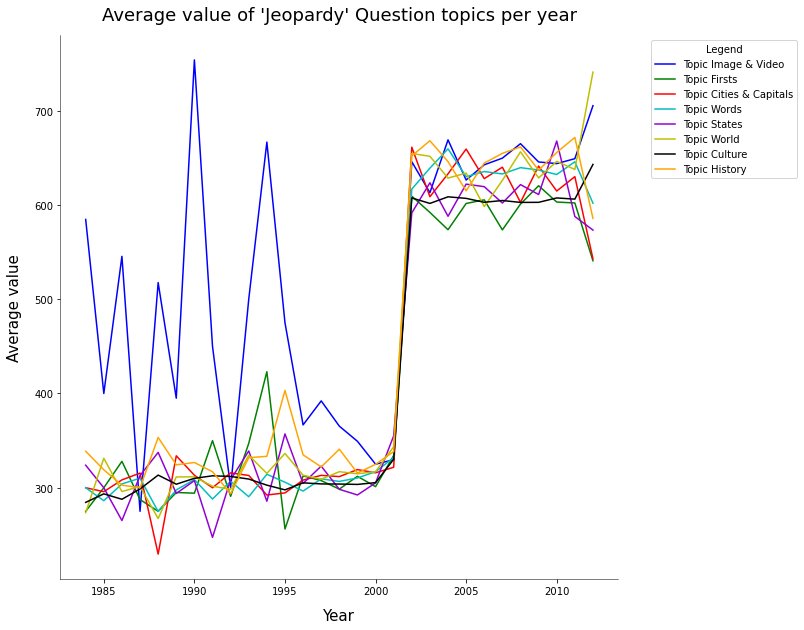

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

length = sorted(df_round_jeopardy['Year'].unique())
colors = ['b','g','r','c','darkviolet','y','k', 'orange', 'lime', 'fuchsia', 'dimgrey']

my_topics = ["Image & Video","Firsts","Cities & Capitals", "Words", "States", "World", "Culture", "History"] 

for topic in range(len(jeopardy_values_per_year)):
    plt.plot(length, jeopardy_values_per_year[topic], color=colors[topic], label=f"Topic {my_topics[topic]}")


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(.5)
ax.spines['left'].set_linewidth(.5)

ax.set_ylabel(f"Average value", fontsize=15, labelpad=12)
ax.set_xlabel("Year", fontsize=15, labelpad=12)
ax.set_title("Average value of 'Jeopardy' Question topics per year", fontsize=18, pad=15)

ax.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

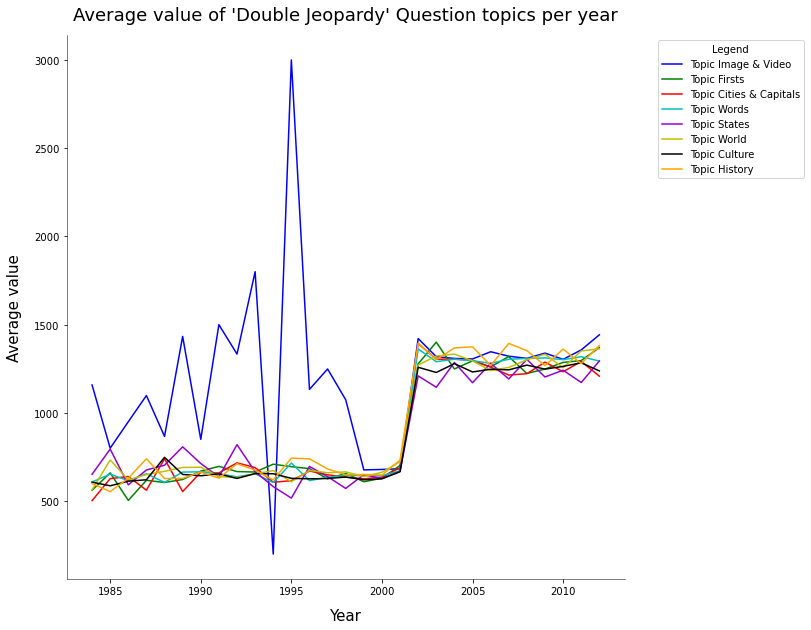

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

length = sorted(df_round_double_jeopardy['Year'].unique())

colors = ['b','g','r','c','darkviolet','y','k', 'orange', 'lime', 'fuchsia', 'dimgrey']

my_topics = ["Image & Video","Firsts","Cities & Capitals", "Words", "States", "World", "Culture", "History"]

for topic in range(len(double_values_per_year)):
    ax.plot(length, double_values_per_year[topic], color=colors[topic], label=f"Topic {my_topics[topic]}")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(.5)
ax.spines['left'].set_linewidth(.5)

ax.set_ylabel(f"Average value", fontsize=15, labelpad=12)
ax.set_xlabel("Year", fontsize=15, labelpad=12)
ax.set_title("Average value of 'Double Jeopardy' Question topics per year", fontsize=18, pad=15)

ax.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()



## Conclusion

While the introduction of images and video seemed to have a large effect on Jeopardy!, the overall structure of the show seems to remain constant over the years. Similarly, the value of these topics has a familiar pattern over the course of the show's life. With a new host coming into Jeopardy! will this change? Tune in next week to find out!


